In [7]:
%reset -f

import sys;
# Import pythonrc
sys.path.append('../')
# Import mccontrolpy
sys.path.append('../../src/')

from pythonrc import *
import numpy as np
import scipy as sc
import skadipy as mc
import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

allocator = skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
    actuators=[
        tunnel,
        voithschneider_port,
        voithschneider_starboard
    ],
    force_torque_components=[
        skadipy.allocator.ForceTorqueComponent.X,
        skadipy.allocator.ForceTorqueComponent.Y,
        skadipy.allocator.ForceTorqueComponent.N,
    ],
    gamma=0.0001,
    mu=0.001,
    rho=0.4,
    control_barrier_function=skadipy.safety.ControlBarrierFunctionType.SUMSQUARE,
    # derivative=mc.toolbox.derivative.ExponentialSmoothing(r=0.5)
)
allocator.compute_configuration_matrix()

In [8]:
def plot_force(actuator: mc.actuator.ActuatorBase, axes: plt.axes):
    pos = actuator.position
    f = np.zeros((3,1))
    f[:len(actuator.force), :] = actuator.force
    f = actuator.orientation.rotate(f)
    axes.quiver(pos.y, pos.x, f[1], f[0], scale_units='xy', angles='xy',clip_on=False)

def plotter(tau_X, tau_Y, tau_N, fig: plt.figure = None):
    tau = np.array([[tau_X, tau_Y, 0.0, 0.0, 0.0, tau_N]]).T

    xi = allocator.allocate(tau=tau)
    tau_alloc = np.reshape(allocator.allocated, (6,))

    if fig is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    else:
        ax1, ax2 = fig.axes

    ax1.axis('equal')

    ax1.grid(True)

    plot_force(tunnel, ax1)
    plot_force(voithschneider_port, ax1)
    plot_force(voithschneider_starboard, ax1)

    efforts = np.array([
        sc.linalg.norm(tunnel.force),
        sc.linalg.norm(voithschneider_port.force),
        sc.linalg.norm(voithschneider_starboard.force)
    ])
    ax2.bar(('tunnel', 'port', 'starboard'), efforts)
    # ax2.set(ylim=[0, 1.5])
    ax2.grid(True)

    fig.canvas.draw()

Button(description='Step', style=ButtonStyle())

FloatSlider(value=0.0, description='tau_X', max=50.0, min=-50.0, step=0.005)

FloatSlider(value=0.0, description='tau_Y', max=50.0, min=-50.0, step=0.005)

FloatSlider(value=0.0, description='tau_N', max=10.0, min=-10.0, step=0.005)

Output()

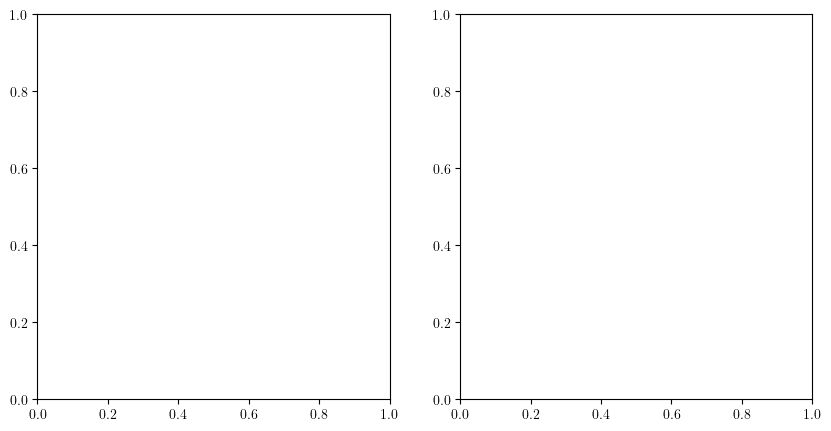

In [9]:
tau_X_widget = widgets.FloatSlider(min=-50.0, max=50.0, step=0.005, description='tau_X')
tau_Y_widget = widgets.FloatSlider(min=-50.0, max=50.0, step=0.005, description='tau_Y')
tau_N_widget = widgets.FloatSlider(min=-10.0, max=10.0, step=0.005, description='tau_N')

button = widgets.Button(description="Step")
output = widgets.Output()

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

def on_button_clicked(b):
    with output:
        output.clear_output(wait=True)
        ax1.clear()
        ax2.clear()
        plotter(tau_X_widget.value, tau_Y_widget.value, tau_N_widget.value, fig=fig)
        # fig.draw(fig.canvas.get_renderer())
        display(fig)

button.on_click(on_button_clicked)
# display(output)
display(button,  tau_X_widget, tau_Y_widget, tau_N_widget, output)

In [4]:
dof_indices = [i.value for i in allocator.force_torque_components]
xi = np.zeros((allocator._b_matrix[dof_indices, :].shape[1], 1), dtype=np.float32)
